<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 11: Análisis de Componentes Principales (PCA), Aplicación</span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

# Clasificación con y sin PCA: impacto en desempeño y tiempos de cómputo

**Objetivo.** Comparar un clasificador base frente al mismo clasificador precedido por **PCA**, midiendo:
- Exactitud y AUC (one-vs-rest, multiclase).
- **Tiempo de entrenamiento** y **tiempo de predicción**.
- Número de **componentes** retenidos vs **varianza explicada**.

Usaremos el dataset **Digits** (`sklearn.datasets.load_digits`), con 1797 imágenes (8x8) → **64 variables** (niveles de gris). Este dataset es apropiado para observar cómo **PCA** reduce dimensionalidad y acelera cómputo sin sacrificar mucho desempeño.

In [5]:
# Librerías utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter

from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Carga de datos: Digits
Cargamos el dataset, construimos un DataFrame para inspección rápida y separamos variables/etiquetas.

In [2]:
digits = load_digits()
X = digits.data              # (1797, 64)
y = digits.target            # dígitos 0-9

df = pd.DataFrame(X, columns=[f"pix_{i}" for i in range(X.shape[1])])
df["target"] = y
df.head()

,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,pix_9,...,pix_55,pix_56,pix_57,pix_58,pix_59,pix_60,pix_61,pix_62,pix_63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [3]:
# Info
print("Dimensiones del dataset:", df.shape)
print("\nDistribución de clases:")
print(df["target"].value_counts().sort_index())

Dimensiones del dataset: (1797, 65)

Distribución de clases:
target
0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
Name: count, dtype: int64


/var/folders/kk/gbkrt22x1jn_jfmqkw6krfw00000gn/T/ipykernel_21258/2719913701.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette="viridis")


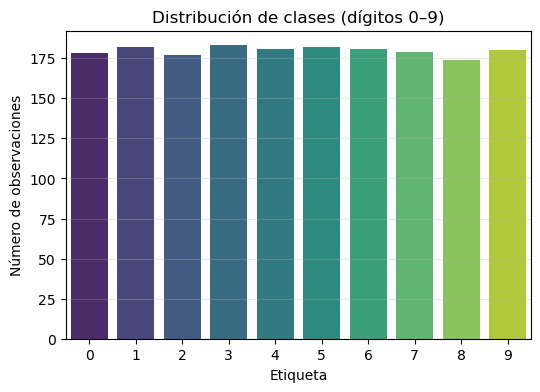

In [6]:
# Distribución de clases
plt.figure(figsize=(6,4))
sns.countplot(x="target", data=df, palette="viridis")
plt.title("Distribución de clases (dígitos 0–9)")
plt.xlabel("Etiqueta")
plt.ylabel("Número de observaciones")
plt.grid(axis="y", alpha=0.3)
plt.show()

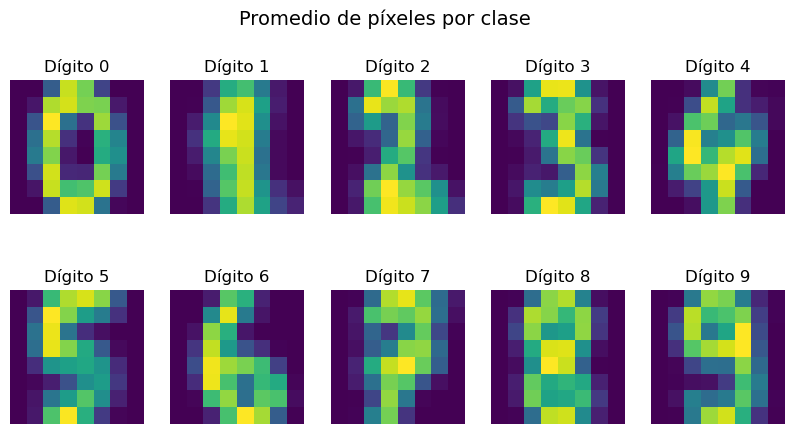

In [8]:
# Visualizar promedio de las imágenes por clase
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    mean_image = X[y == i].mean(axis=0).reshape(8, 8)
    ax.imshow(mean_image, cmap="viridis")
    ax.set_title(f"Dígito {i}")
    ax.axis("off")
plt.suptitle("Promedio de píxeles por clase", fontsize=14)
plt.show()

## Modelos ML

In [9]:
# Validación cruzada
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Métricas y scoring
Trabajaremos con:
- **accuracy**
- **roc_auc_ovr** (AUC multiclase con esquema one-vs-rest)

Además, mediremos tiempos de **ajuste** y **predicción** con `cross_validate`.


In [24]:
scoring = {
    "accuracy": make_scorer(accuracy_score)
}


## Modelos base (sin PCA)
Usaremos dos clasificadores comunes:
- **Regresión Logística** (multiclase, `lbfgs`)
- **SVM** con kernel RBF (probabilidades habilitadas)

Ambos dentro de `Pipeline` con `StandardScaler` por conveniencia.


In [26]:
logreg_base = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, random_state=42))
])

svm_base = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

def evaluar(modelo, X, y, cv=CV, scoring=scoring):
    res = cross_validate(modelo, X, y, cv=cv, scoring=scoring,
                         return_train_score=False,
                         n_jobs=-1,
                         return_estimator=False)
    return pd.DataFrame(res)

res_logreg_base = evaluar(logreg_base, X, y)
res_svm_base    = evaluar(svm_base, X, y)

pd.concat({
    "LR sin PCA": res_logreg_base[["test_accuracy","fit_time","score_time"]].mean(),
    "SVM sin PCA": res_svm_base[["test_accuracy","fit_time","score_time"]].mean()
}, axis=1)

,LR sin PCA,SVM sin PCA
test_accuracy,0.971066,0.983858
fit_time,0.014830,0.158951
score_time,0.000554,0.015698


## Selección de número de componentes con curva de varianza explicada
Calculamos la varianza explicada acumulada para elegir un `n_components` razonable (p.ej. **≥ 95%**).


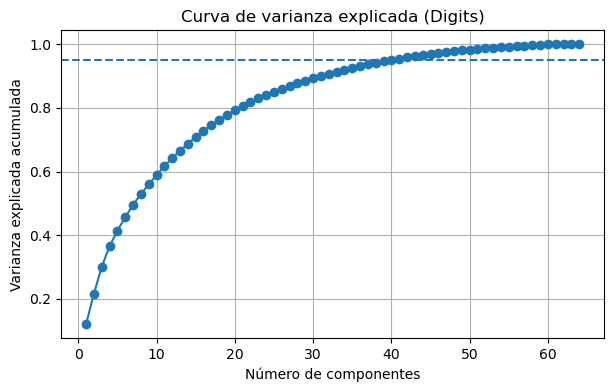

índice donde la varianza explicada supera 95% :  40


In [29]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca_full = PCA().fit(X_std)

var_ratio = pca_full.explained_variance_ratio_
var_acum = np.cumsum(var_ratio)

plt.figure(figsize=(7,4))
plt.plot(range(1, len(var_acum)+1), var_acum, marker="o")
plt.axhline(0.95, linestyle="--")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Curva de varianza explicada (Digits)")
plt.grid(True)
plt.show()

# Sugerencia automática: mínimo k con >= 95% varianza
k95 = np.argmax(var_acum >= 0.95) + 1
print('índice donde la varianza explicada supera 95% : ', k95)

## Modelos con PCA (mismo clasificador, menos dimensiones)
Insertamos `PCA(n_components=k95)` entre el `StandardScaler` y el clasificador.  
Esto suele **acelerar el ajuste** y **reducir overfitting** en ciertos escenarios, manteniendo desempeño competitivo.


In [33]:
logreg_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=k95, random_state=42)),
    ("clf", LogisticRegression(max_iter=5000, random_state=42))
])

svm_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=k95, random_state=42)),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

res_logreg_pca = evaluar(logreg_pca, X, y)
res_svm_pca    = evaluar(svm_pca, X, y)

pd.concat({
    "LR con PCA": res_logreg_pca[["test_accuracy","fit_time","score_time"]].mean(),
    "SVM con PCA": res_svm_pca[["test_accuracy","fit_time","score_time"]].mean()
}, axis=1)

,LR con PCA,SVM con PCA
test_accuracy,0.968279,0.983302
fit_time,0.014363,0.116476
score_time,0.000671,0.014114


In [35]:
def resumen(df, etiqueta):
    m = df[["test_accuracy","fit_time","score_time"]].mean()
    m.name = etiqueta
    return m

tabla = pd.concat([
    resumen(res_logreg_base, "LR sin PCA"),
    resumen(res_logreg_pca,  f"LR con PCA (k={k95})"),
    resumen(res_svm_base,    "SVM sin PCA"),
    resumen(res_svm_pca,     f"SVM con PCA (k={k95})"),
], axis=1).T

tabla

,test_accuracy,fit_time,score_time
LR sin PCA,0.971066,0.014830,0.000554
LR con PCA (k=40),0.968279,0.014363,0.000671
SVM sin PCA,0.983858,0.158951,0.015698
SVM con PCA (k=40),0.983302,0.116476,0.014114


In [37]:
# Evaluación 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

modelos = {
    "LR sin PCA": logreg_base,
    f"LR con PCA (k={k95})": logreg_pca,
    "SVM sin PCA": svm_base,
    f"SVM con PCA (k={k95})": svm_pca,
}

resultados = {}
for nombre, modelo in modelos.items():
    t0 = perf_counter()
    modelo.fit(X_train, y_train)
    t1 = perf_counter()
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)
    t2 = perf_counter()

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
    resultados[nombre] = {"accuracy": acc, "roc_auc_ovr": auc, 
                          "fit_time": t1 - t0, "score_time": t2 - t1}

pd.DataFrame(resultados).T

,accuracy,roc_auc_ovr,fit_time,score_time
LR sin PCA,0.977778,0.999081,0.028696,0.000753
LR con PCA (k=40),0.960000,0.998489,0.012912,0.000575
SVM sin PCA,0.980000,0.999226,0.144968,0.041916
SVM con PCA (k=40),0.982222,0.999122,0.105048,0.030456


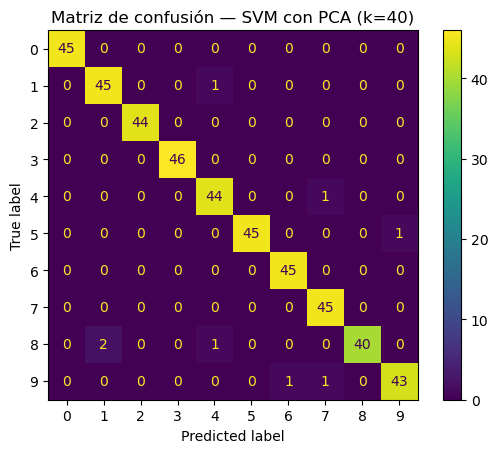

Reporte de clasificación — SVM con PCA (k=40)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.96      0.98      0.97        46
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        46
           4       0.96      0.98      0.97        45
           5       1.00      0.98      0.99        46
           6       0.98      1.00      0.99        45
           7       0.96      1.00      0.98        45
           8       1.00      0.93      0.96        43
           9       0.98      0.96      0.97        45

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [38]:
# Matriz de confusión de uno de los modelos
modelo_ref = f"SVM con PCA (k={k95})"
mdl = modelos[modelo_ref].fit(X_train, y_train)
y_pred_ref = mdl.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ref)
plt.title(f"Matriz de confusión — {modelo_ref}")
plt.show()

print(f"Reporte de clasificación — {modelo_ref}")
print(classification_report(y_test, y_pred_ref))

## Conclusiones rápidas
- **PCA reduce dimensionalidad** (de 64 a $k$ componentes reteniendo ≥ 95% de varianza), lo cual suele **acelerar tiempos de entrenamiento** y, en muchos casos, **mantener** la exactitud/AUC en rangos muy similares al baseline.  
- En datasets con alta colinealidad o mucho ruido, PCA puede incluso **mejorar** la generalización al eliminar direcciones de baja varianza que aportan poco al modelo.  
- La elección de $k$ puede guiarse por la **curva de varianza explicada** (e.g., 90–99%), o por **validación** optimizando desempeño-tiempo.
